# Machine Learning with PySpark on the "Titanic: Machine Learning from Disaster" challenge dataset

This notebook shows how to learn statistical models for predicting the survival rate of the passengers in the Titanic cruise ship. The dataset's statistical analysis and visualization is in a separate notebook named **"Data Analysis and Visualizations.ipynb"** found in the same directory as this one. Here we'll only tackle the use of Spark's Python wrapper library **pyspark** for learning a model to predict if a passengers survived of nor the shipwreck.

We'll use several popular methods for statistical learning for modeling our data, such as:

  - Logistic Regression
  - Decision Trees
  - Random Forests
  - Gradient Boosting Trees
  - Neural networks

Then, we'll combine all models and create an ensemble of models to predict the survival label on a test set.

This notebook is structured as follow:

  1. **Load data**
  
      1.1. Import libraries

      1.2. Load preprocessed files
      
      1.3. Setup training and testing data 

  2. **Model selection, training and evaluation**
  
      2.1. Import models from scikit-learn
      
      2.2. Setup models' parameters
      
      2.3. Train the models using cross validation
      
      2.4. Analyse the models accuracy
      
      2.5. (optional): plot the best features of all models for visual analysis
  
  3. **Model prediction**
      
      3.1. Predict and Submit results

## 1. Load data

### 1.1. Import libraries

In [1]:
# Import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
# Import a Spark session
from pyspark.sql import SparkSession

In [3]:
# create spark session
spark = SparkSession.builder.appName('Titanic').getOrCreate()

### 1.2. Load preprocessed files

In [4]:
# Load pre-processed train and test data sets
train = spark.read.csv('data/train_processed.csv', inferSchema=True, header=True)
test = spark.read.csv('data/test_processed.csv', inferSchema=True, header=True)

In [5]:
train.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Age: double (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Name: string (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- PassengerId: integer (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Survived: double (nullable = true)
 |-- Family_size: integer (nullable = true)
 |-- Ticket_A: integer (nullable = true)
 |-- Ticket_A4: integer (nullable = true)
 |-- Ticket_A5: integer (nullable = true)
 |-- Ticket_AQ3: integer (nullable = true)
 |-- Ticket_AQ4: integer (nullable = true)
 |-- Ticket_AS: integer (nullable = true)
 |-- Ticket_C: integer (nullable = true)
 |-- Ticket_CA: integer (nullable = true)
 |-- Ticket_CASOTON: integer (nullable = true)
 |-- Ticket_FC: integer (nullable = true)
 |-- Ticket_FCC: integer (nullable = true)
 |-- Ticket_Fa: integer (nullable = true)
 |-- Ticket_LINE: integer (nullable = true)
 |-- Ticket_LP: integer (nullable = true)
 |-- Ticket_PC: integer (nullable = true)
 |-- Ticke

### 1.3. Setup feature and label columns

Pyspark uses a Dense vector to represent a set of features that are then used by the statistical models from the MLlib library. Therefore, the features need to be set up w.r.t. the format thet models expect the data to be in.

In [6]:
# Import vector assembler function for grouping columns into a vector
from pyspark.ml.feature import VectorAssembler

In [7]:
# Drop unused features and create an assembler of features
feature_columns = [feature for feature in train.columns if feature not in ['_c0', 'Name', 'Survived', 'PassengerId', 'Family_size']]
feature_assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# 2. Model Selection, training and evaluation

This section deals with selecting a model for training on the training set and then evaluating its performance against other models.

We'll use the most of popular models from the pyspark's MLlib library for classification. Namely, we'll use:

  - Logistic Regression
  - Decision Trees
  - Random Forests
  - Gradient Boosting
  - Neural networks

This notebook doesn't focus on evaluating every single model from the MLlib library but only the (arguably) most popular models for classification tasks available for use. 

> Note: Any other model that has not been used here can easily be integrated in this notebook with little effort.

### 2.1. Import models from MLlib

In [8]:
# Import models for classification
from pyspark.ml.classification import (
    LogisticRegression, 
    DecisionTreeClassifier, 
    RandomForestClassifier, 
    GBTClassifier, 
    MultilayerPerceptronClassifier
)

### 2.2. Setup models' parameters

In [9]:
# Import parameters grid builder (for grid search)
from pyspark.ml.tuning import ParamGridBuilder

In [10]:
# Random seed for the train procedure
random_seed = 2

In [11]:
# Setup models
lr_model = LogisticRegression(featuresCol='features', labelCol='Survived')
dtree_model = DecisionTreeClassifier(featuresCol='features', labelCol='Survived')
rforest_model = RandomForestClassifier(featuresCol='features', labelCol='Survived')
gbt_model = GBTClassifier(featuresCol='features', labelCol='Survived')
nn_model = MultilayerPerceptronClassifier(featuresCol='features', labelCol='Survived')

In [12]:
# Setup models + parameters
classifiers = {
    "Logistic_Regression": {
        "model": lr_model,
        "alias": 'LReg',
        "params": ParamGridBuilder() \
                    .addGrid(lr_model.regParam, [0.1, 0.01]) \
                    .addGrid(lr_model.maxIter, [100, 200, 300]) \
                    .build()
    },
    "Decision_Trees": {
        "model": dtree_model,
        "alias": 'DTree',
        "params": ParamGridBuilder() \
                    .addGrid(dtree_model.getMaxDepth, [5, 10, 15]) \
                    .addGrid(dtree_model.maxBins, [16, 32, 48, 64]) \
                    .build()
    },
    "Random_Forest": {
        "model": rforest_model,
        "alias": 'RFT',
        "params": ParamGridBuilder() \
                    .addGrid(rforest_model.getMaxDepth, [5, 10, 15]) \
                    .addGrid(rforest_model.maxBins, [16, 32, 48, 64]) \
                    .addGrid(rforest_model.numTrees, [20, 50, 100, 150, 200]) \
                    .build()
    },
    "Gradient_Boosting": {
        "model": gbt_model,
        "alias": 'GBT',
        "params": ParamGridBuilder() \
                    .addGrid(gbt_model.maxIter, [10, 20, 30, 40, 50]) \
                    .addGrid(gbt_model.maxDepth, [2, 4, 6, 8, 10]) \
                    .build()
    },
    "Neural_Network": {
        "model": nn_model,
        "alias": 'NN',
        "params": ParamGridBuilder() \
                    .addGrid(nn_model.layers, [[67, 256, 128, 2], [67, 128, 2], [67, 256, 2], [67, 128, 256, 2]]) \
                    .addGrid(nn_model.stepSize, [0.3, 0.1, 0.01, 0.001]) \
                    .addGrid(nn_model.maxIter, [100, 200]) \
                    .addGrid(nn_model.blockSize, [128, 256]) \
                    .build()
    },
}

### 2.3. Train the models using cross validation

In [13]:
# Import necessary functions
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator
from pyspark.ml import Pipeline

In [14]:
%%time

# Train all models using cross validation and randomized search for hyperparameter tunning

import time

# Number of cross validation splits
cross_val_splits = 10

# Store the train results in a var
results = {}

# Train all models
total_models = len(classifiers)
for i, model_name in enumerate(classifiers):
    start = time.time()
    print('({}/{}) {}: start training model... '.format(i+1, total_models, model_name), end="", flush=True)
    
    # Fetch the model to train
    clf = classifiers[model_name]['model']
    
    # Fetch the model parameters
    paramGrid = classifiers[model_name]['params']
    
    # Create pipeline
    pipeline = Pipeline(stages=[feature_assembler, clf])
    
    # Create a cross validation object to train the model
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=BinaryClassificationEvaluator(labelCol='Survived'),
                              numFolds=cross_val_splits)

    # Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(train)

    # Store the model results in a dictionary
    results[model_name] = cvModel
    
    print('Done! Elapsed time: {}s\n'.format(time.time() - start))

(1/5) Logistic_Regression: start training model... Done! Elapsed time: 61.56623721122742s

(2/5) Decision_Trees: start training model... Done! Elapsed time: 48.14426064491272s

(3/5) Random_Forest: start training model... Done! Elapsed time: 380.77828311920166s

(4/5) Gradient_Boosting: start training model... Done! Elapsed time: 1893.5972657203674s

(5/5) Neural_Network: start training model... Done! Elapsed time: 6768.744810581207s

CPU times: user 1min 15s, sys: 14.3 s, total: 1min 29s
Wall time: 2h 32min 32s


### 2.4 Analyse the models accuracy

Here we'll father which model gave the best results from all 5 of them. Then, we'll select the best model for predicting the survival label of all passengers of the tests et of the Titanic dataset.

In [15]:
# Compute the mean + std for all models
results_mean_std = []
for model_name in results:
    # Get the model random/grid search results
    results_model = results[model_name]
    
    # Compute mean + std and add it to a list
    results_mean_std.append({
        "model": model_name,
        "mean": np.mean(results_model.avgMetrics),
        "std": np.std(results_model.avgMetrics)
    })

In [16]:
# Create a Pandas DataFrame with the mean+std results
accuracy_df = pd.DataFrame(results_mean_std, columns=['model', 'mean', 'std'])

In [17]:
# Show the accuracy dataframe
accuracy_df

,model,mean,std
0,Logistic_Regression,0.879734,0.000676
1,Decision_Trees,0.681691,0.018634
2,Random_Forest,0.875976,0.001887
3,Gradient_Boosting,0.865141,0.017635
4,Neural_Network,0.867643,0.004538


Text(0.5,1,'Cross validation accuracy scores')

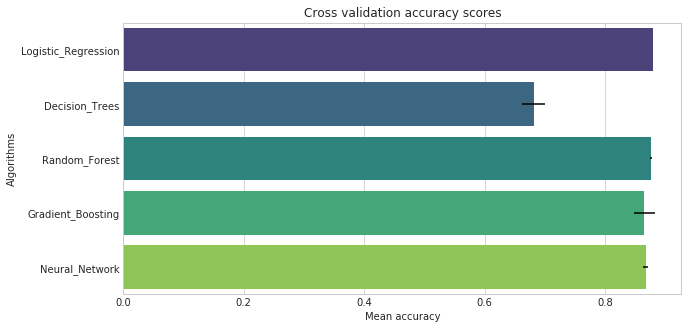

In [18]:
# Plot the mean accuracy for all models
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
g = sns.barplot(data=accuracy_df, y='model', x='mean', orient='h', **{'xerr':accuracy_df['std']}, palette='viridis', ax=ax)
g.set_ylabel('Algorithms')
g.set_xlabel('Mean accuracy')
g.set_title('Cross validation accuracy scores')

Here we have the result of the accuracy of all models trained. From these, the model with the best accuracy was the **Logistic_Regression** model with 87.97% accuracy with 0.07% standard deviation.

In [19]:
# Create a prediction of all models on the test set
predictions_all = {}
for model_name in results:
    # Get best estimator
    best_model = results[model_name].bestModel
    
    # Predict test labels
    predictions = best_model.transform(test)
    
    # Convert to pandas DataFrame
    predictions_df = predictions.select('prediction').toPandas()
    
    # Save predictions to a list
    predictions_all[model_name] = predictions_df['prediction']

In [20]:
# Creat a DataFrame for the predictions
pred = pd.DataFrame(predictions_all)

Text(0.5,1,'Correlation of the test set label prediction between models')

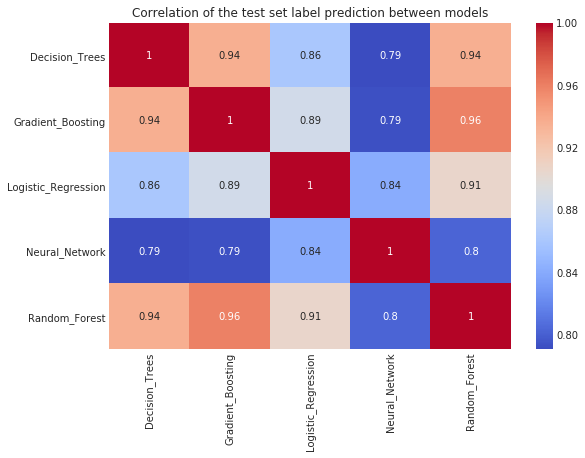

In [21]:
# Plot a heatmap of all correlations to see how the models are correlated with each other
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
g = sns.heatmap(pred.corr(), annot=True, cmap='coolwarm', ax=ax)
g.set_title('Correlation of the test set label prediction between models')

We see that the models are all very correlated in their predictions. This indicates that the models predict similarly the same way and are comparable in performance.

### 2.5. (optional): plot the best features of all models for visual analysis

In this subsection, the feature importance is plotted for all models in order to visually see which features were more important for each model 

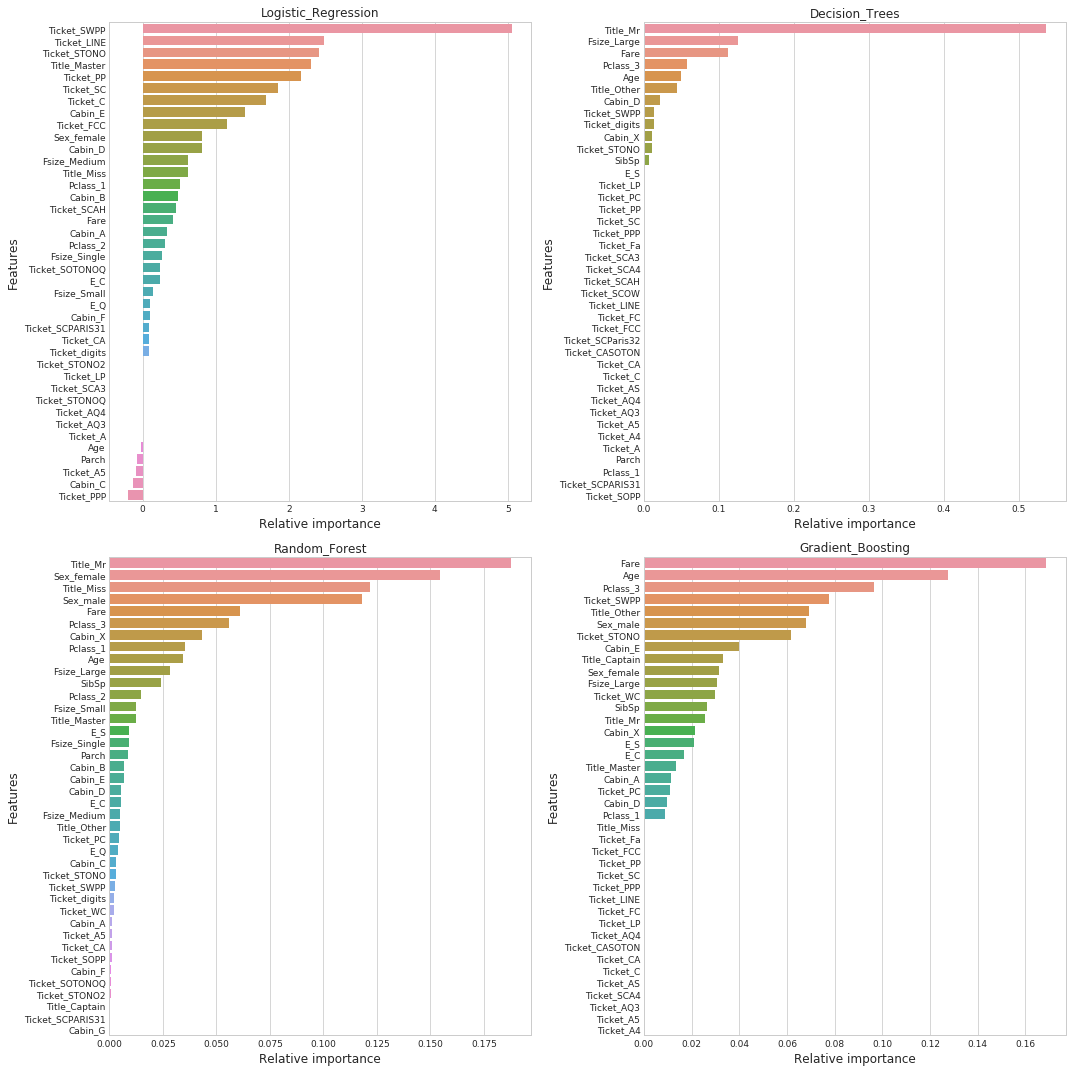

In [22]:
# Create figure
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(15,15))

# get a list of flat axes
if type(axes[0]) == np.ndarray:
    flat_axes = [ax for axes_ in axes for ax in axes_]
else:
    flat_axes = [ax for ax in axes]

# Get model names 
model_names = list(results.keys())

# Get feature names
feature_names = feature_columns

# Cycle all models and plot them
for i, model_name in enumerate(results):
    if not model_name in ['Neural_Network']:
        
        # Model estimator
        model = results[model_name].bestModel.stages[1]

        try:
            model_features = model.coefficients
        except AttributeError:
            model_features = model.featureImportances
        
        # Get the top 40 features
        model_features = np.array(list(model_features))
        indices = np.argsort(model_features)[::-1][:40]
        feats = model_features[indices][:40]
        labels = list(np.array(feature_columns)[indices][:40])

        # Plot the features sorted by their importance
        g = sns.barplot(y=labels, x = feats, orient='h', ax=flat_axes[i])
        g.set_xlabel("Relative importance", fontsize=12)
        g.set_ylabel("Features", fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(model_name)
plt.tight_layout()

Here we have a list of the top-40 features for all algorithms. We can see that all have different selections of features and different importance levels for each. However, some top-performing fields are common to all like the title of a passenger for example.

## 3. Model prediction

### 3.1. Predict and Submit results

In [23]:
# Select the best model and predict the survival label for passengers of the test set
# Here we'll use the **Random Forest model** for prediction because it offers
# better accuracy compared to **Logistic_Regression**
bestModel = results['Random_Forest'].bestModel

# Compute the final predictions
final_predictions = bestModel.transform(test)

In [24]:
# Combine the passenger ID with the Survived labels
final_predictions_df = final_predictions.select('prediction').toPandas()

# Rename colum to 'Survived'
final_predictions_df.columns = ['Survived']
final_predictions_df['Survived'] = final_predictions_df['Survived'].astype(int)

# Load the test set as a pandas DataFrame to get the 'PassengerId' column
test_df = pd.read_csv('data/test.csv')
test_results = pd.concat([test_df['PassengerId'], final_predictions_df], axis=1)

# Export predictions
test_results.to_csv("data/pyspark_prediction_random_forest.csv", index=False)